# **PRICE SENSITIVITY ANALYSIS**

STEP 1 — Install and Import Libraries

In [ ]:
# Install (if needed) and import libraries
!pip install scipy numpy matplotlib

import numpy as np
import scipy.io
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt

print("Libraries installed and imported successfully ✅")


Libraries installed and imported successfully ✅


STEP 2 - Upload and Load S01.mat File in Colab

In [ ]:
# Upload S01.mat file
from google.colab import files

uploaded = files.upload()

# Load the uploaded .mat file
import scipy.io

mat_file_path = list(uploaded.keys())[0]  # Automatically get uploaded file name
mat_contents = scipy.io.loadmat(mat_file_path)

print("File uploaded and loaded successfully ✅")


Saving S01.mat to S01.mat
File uploaded and loaded successfully ✅


 STEP 3 — Extract EEG Data, Sampling Rate, Channels

In [ ]:
# Extract EEG_clean structure from loaded mat file
S01_data = mat_contents['S01']

# Now extract EEG_clean field
EEG_clean_struct = S01_data['EEG_clean'][0, 0]

# Finally extract the actual EEG data, sampling rate, and channels
eeg_data = EEG_clean_struct['Data'][0, 0]      # (19 channels × timepoints)
fs = EEG_clean_struct['Fs'][0, 0].item()        # Sampling frequency
chans = EEG_clean_struct['chans'][0, 0]         # Channel labels

print("EEG data shape:", eeg_data.shape)
print("Sampling frequency:", fs)
print("Number of channels:", chans.shape[-1])


EEG data shape: (19, 110400)
Sampling frequency: 300
Number of channels: 19


STEP 4 — Preprocess EEG (Filtering)

In [ ]:
# Define EEG preprocessing function
from scipy.signal import butter, filtfilt

def eeg_preprocessing(EEG_raw, Fs):
    """
    Preprocess EEG data by bandpass filtering (0.5-45 Hz)
    """
    # Define bandpass frequencies
    lowcut = 0.5
    highcut = 45.0
    nyq = 0.5 * Fs
    low = lowcut / nyq
    high = highcut / nyq

    # Design a 3rd order Butterworth bandpass filter
    b, a = butter(3, [low, high], btype='band')

    # Apply zero-phase filtering
    EEG_filt = filtfilt(b, a, EEG_raw, axis=1)

    # For now, EEG_clean = EEG_filt
    EEG_clean = EEG_filt.copy()

    return EEG_filt, EEG_clean

# Apply preprocessing
eeg_filt, eeg_clean = eeg_preprocessing(eeg_data, fs)

print("Filtered EEG shape:", eeg_filt.shape)
print("Preprocessing done ✅")


Filtered EEG shape: (19, 110400)
Preprocessing done ✅


 STEP 5 — Save Extracted Features for ML (Price Sensitivity Work)

In [ ]:
# Re-define Compute Band Powers Function
from scipy.signal import welch

def compute_bandpower(eeg_data, fs, band, window_sec=2):
    """
    Compute average power in a frequency band using Welch's method
    """
    bandpower = []
    win = int(window_sec * fs)
    for channel_data in eeg_data:
        freqs, psd = welch(channel_data, fs, nperseg=win)
        freq_res = freqs[1] - freqs[0]
        idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
        band_power = np.sum(psd[idx_band]) * freq_res
        bandpower.append(band_power)
    return np.array(bandpower)

def compute_multiple_bandpowers(eeg_data, fs):
    """
    Compute Delta, Theta, Alpha, Beta, Gamma bandpowers
    """
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 45)
    }
    features = {}
    for band_name, band_range in bands.items():
        features[band_name] = compute_bandpower(eeg_data, fs, band=band_range)
    return features

print("Bandpower computation functions ready ✅")


Bandpower computation functions ready ✅


In [ ]:
bandpowers = compute_multiple_bandpowers(eeg_clean, fs)

In [ ]:
# Combine all band features into a single matrix: (channels x bands)
feature_matrix = np.stack([
    bandpowers['Delta'],
    bandpowers['Theta'],
    bandpowers['Alpha'],
    bandpowers['Beta'],
    bandpowers['Gamma']
], axis=1)

print("Feature matrix shape (channels x bands):", feature_matrix.shape)

# Save it
np.savez('eeg_bandpowers.npz', feature_matrix=feature_matrix)

print("Bandpower features saved to 'eeg_bandpowers.npz' ✅")


Feature matrix shape (channels x bands): (19, 5)
Bandpower features saved to 'eeg_bandpowers.npz' ✅


STEP 6 — Create Synthetic Labels

In [ ]:
# Create synthetic labels

import numpy as np

# Let's assume 19 channels = 19 products shown
n_samples = eeg_clean.shape[0]

# Random labels: 0 = Not Interested, 1 = Interested
np.random.seed(42)  # for reproducibility
synthetic_labels = np.random.choice([0, 1], size=n_samples)

print("Synthetic labels generated:", synthetic_labels)

# Save them
np.save('synthetic_labels.npy', synthetic_labels)
print("Synthetic labels saved to 'synthetic_labels.npy' ✅")


Synthetic labels generated: [0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1]
Synthetic labels saved to 'synthetic_labels.npy' ✅


 STEP 7 — Build and Train Machine Learning Model

In [ ]:
# Build and train a simple machine learning model

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load features and labels
data = np.load('eeg_bandpowers.npz')
X = data['feature_matrix']
y = np.load('synthetic_labels.npy')

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[2 1]
 [2 1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.50      0.33      0.40         3

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6

Accuracy Score: 0.5


Step 9 - Exact Actions:

In [ ]:
# Install if needed
!pip install openpyxl

import pandas as pd

# Read S01.xlsx
xlsx_path = '/content/S01.xlsx'  # Adjust if your file is somewhere else
labels_df = pd.read_excel(xlsx_path)

# Display the first few rows
print(labels_df.head())


                                          Subject ID   Age  Gender  Hand  \
0                                                S01  24.0     1.0   1.0   
1                                                ...   NaN     NaN   NaN   
2                                                NaN   NaN     NaN   NaN   
3                                                NaN   NaN     NaN   NaN   
4                                                NaN   NaN     NaN   NaN   

   Education  Marital Status  Children   Q1   Q2   Q3  ...  Q69  Q70  Q71  \
0        5.0             1.0       2.0  1.0  1.0  7.0  ...  2.0  3.0  2.0   
1        NaN             NaN       NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2        NaN             NaN       NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3        NaN             NaN       NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4        NaN             NaN       NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

   Q72  Q73  Q74  Q75  Q76  Q77  Q78  
0  3.0  1.0  4.0  0.0  16I  16A  16D  
1 

In [ ]:
# Check available columns first
print(labels_df.columns)


Index(['Subject ID', 'Age', 'Gender', 'Hand', 'Education', 'Marital Status',
       'Children', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10',
       'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
       'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30',
       'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40',
       'Q41', 'Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49', 'Q50',
       'Q51', 'Q52', 'Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60',
       'Q61', 'Q62', 'Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70',
       'Q71', 'Q72', 'Q73', 'Q74', 'Q75', 'Q76', 'Q77', 'Q78'],
      dtype='object')


In [ ]:
# Install pyxdf library to load .xdf files
!pip install pyxdf

import pyxdf

# Load the .xdf file
xdf_file_path = '/content/S01 (1).xdf'  # Adjust if path is different
streams, header = pyxdf.load_xdf(xdf_file_path)

print("Number of streams found:", len(streams))
for i, stream in enumerate(streams):
    print(f"\nStream {i}:")
    print("  Name:", stream['info']['name'][0])
    print("  Type:", stream['info']['type'][0])


Number of streams found: 5

Stream 0:
  Name: MyMarkerStream3
  Type: Markers

Stream 1:
  Name: MouseButtons
  Type: Markers

Stream 2:
  Name: Tobii
  Type: Eyetracker

Stream 3:
  Name: MousePosition
  Type: Position

Stream 4:
  Name: WS-default
  Type: EEG


In [ ]:
# Extract MouseButtons stream
mouse_stream = streams[1]  # Stream 1 = MouseButtons

# Extract timestamps and click events
click_times = mouse_stream['time_stamps']
click_labels = [m[0] for m in mouse_stream['time_series']]  # Click event labels

# Show first few click events
for time, label in zip(click_times[:10], click_labels[:10]):
    print(f"Click at {time:.2f} sec - Event: {label}")


Click at 332974.24 sec - Event: MouseButtonLeft pressed
Click at 332974.30 sec - Event: MouseButtonLeft released
Click at 333114.63 sec - Event: MouseButtonLeft pressed
Click at 333114.71 sec - Event: MouseButtonLeft released
Click at 333118.69 sec - Event: MouseButtonLeft pressed
Click at 333118.87 sec - Event: MouseButtonLeft released
Click at 333169.11 sec - Event: MouseButtonLeft pressed
Click at 333169.24 sec - Event: MouseButtonLeft released
Click at 333204.18 sec - Event: MouseButtonLeft pressed
Click at 333204.29 sec - Event: MouseButtonLeft released


In [ ]:
# Extract MyMarkerStream3 (Stimulus events)
marker_stream = streams[0]  # Stream 0 = MyMarkerStream3

# Extract timestamps and event labels
stimulus_times = marker_stream['time_stamps']
stimulus_labels = [m[0] for m in marker_stream['time_series']]  # Marker event labels

# Show first few stimulus events
for time, label in zip(stimulus_times[:20], stimulus_labels[:20]):
    print(f"Stimulus at {time:.2f} sec - Event: {label}")


Stimulus at 332979.19 sec - Event: fixation_cross
Stimulus at 333148.91 sec - Event: Category:IMG=ID:FYLLADIO_1.tif=Type:Leaflet_Images_1
Stimulus at 333176.63 sec - Event: Category:IMG=ID:FYLLADIO_2.tif=Type:Leaflet_Images_1
Stimulus at 333206.05 sec - Event: Category:IMG=ID:FYLLADIO_3.tif=Type:Leaflet_Images_1
Stimulus at 333227.84 sec - Event: Category:IMG=ID:FYLLADIO_4.tif=Type:Leaflet_Images_1
Stimulus at 333232.45 sec - Event: Category:IMG=ID:FYLLADIO_5.tif=Type:Leaflet_Images_1
Stimulus at 333239.03 sec - Event: Category:IMG=ID:FYLLADIO_6.tif=Type:Leaflet_Images_1
Stimulus at 333239.85 sec - Event: Category:IMG=ID:FYLLADIO_5.tif=Type:Leaflet_Images_1
Stimulus at 333243.71 sec - Event: Category:IMG=ID:FYLLADIO_6.tif=Type:Leaflet_Images_1
Stimulus at 333252.71 sec - Event: Category:IMG=ID:FYLLADIO_1.tif=Type:Leaflet_Images_1
Stimulus at 333294.31 sec - Event: Category:IMG=ID:FYLLADIO_2.tif=Type:Leaflet_Images_1
Stimulus at 333300.30 sec - Event: Category:IMG=ID:FYLLADIO_3.tif=Type

In [ ]:
# PARAMETERS
reaction_window = 15  # seconds after stimulus to accept a click as "Buy"

# Build stimulus list
stimulus_info = list(zip(stimulus_times, stimulus_labels))

# Filter to only product presentations (skip fixation_cross, EOE, etc.)
product_stimuli = [(t, lbl) for (t, lbl) in stimulus_info if 'IMG=ID' in lbl]

print(f"Total products presented: {len(product_stimuli)}")

# Initialize labels: 0 (NoBuy) for all products first
product_labels = np.zeros(len(product_stimuli))

# Match clicks to products
for i, (stim_time, stim_label) in enumerate(product_stimuli):
    # Find any click within reaction_window after this stimulus
    for click_time in click_times:
        if stim_time < click_time <= stim_time + reaction_window:
            # If click happens in reaction window, mark as Buy (1)
            product_labels[i] = 1
            break  # Only need one click to consider as Buy

# Preview
for i, (stim_time, stim_label) in enumerate(product_stimuli):
    print(f"Product {i+1}: {stim_label} at {stim_time:.2f}s --> Label: {'Buy' if product_labels[i]==1 else 'NoBuy'}")


Total products presented: 17
Product 1: Category:IMG=ID:FYLLADIO_1.tif=Type:Leaflet_Images_1 at 333148.91s --> Label: NoBuy
Product 2: Category:IMG=ID:FYLLADIO_2.tif=Type:Leaflet_Images_1 at 333176.63s --> Label: NoBuy
Product 3: Category:IMG=ID:FYLLADIO_3.tif=Type:Leaflet_Images_1 at 333206.05s --> Label: Buy
Product 4: Category:IMG=ID:FYLLADIO_4.tif=Type:Leaflet_Images_1 at 333227.84s --> Label: Buy
Product 5: Category:IMG=ID:FYLLADIO_5.tif=Type:Leaflet_Images_1 at 333232.45s --> Label: Buy
Product 6: Category:IMG=ID:FYLLADIO_6.tif=Type:Leaflet_Images_1 at 333239.03s --> Label: Buy
Product 7: Category:IMG=ID:FYLLADIO_5.tif=Type:Leaflet_Images_1 at 333239.85s --> Label: Buy
Product 8: Category:IMG=ID:FYLLADIO_6.tif=Type:Leaflet_Images_1 at 333243.71s --> Label: Buy
Product 9: Category:IMG=ID:FYLLADIO_1.tif=Type:Leaflet_Images_1 at 333252.71s --> Label: NoBuy
Product 10: Category:IMG=ID:FYLLADIO_2.tif=Type:Leaflet_Images_1 at 333294.31s --> Label: NoBuy
Product 11: Category:IMG=ID:FYLL

In [ ]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# Load your EEG features
# Here, assuming eeg_clean is already loaded (preprocessed EEG)

# (OPTIONAL) If needed: re-extract bandpowers for only the stimulus period
# For now, use what you extracted earlier: compute_multiple_bandpowers(eeg_clean, fs)

# We already have 'product_labels' (0 = NoBuy, 1 = Buy) from matching clicks

# Quick reminder: How many EEG features do we have per product?
print("Number of EEG samples (products):", len(product_labels))

# For simplicity, let's simulate features here
# In reality, you would extract EEG features segment-wise per product
# But since we don't have segmented EEG yet, I'll create dummy features for 17 products
# (Later, you can match to real EEG segments)

# Simulate features: (17 products x 5 bands: Delta, Theta, Alpha, Beta, Gamma)
np.random.seed(42)
X_features = np.random.rand(len(product_labels), 5)  # 5 band powers

# Labels
y_labels = product_labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("\n--- Model Evaluation ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Number of EEG samples (products): 17

--- Model Evaluation ---
Confusion Matrix:
 [[0 3]
 [1 2]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.40      0.67      0.50         3

    accuracy                           0.33         6
   macro avg       0.20      0.33      0.25         6
weighted avg       0.20      0.33      0.25         6

Accuracy Score: 0.3333333333333333


In [ ]:
# Install pyxdf and tqdm if not installed
!pip install pyxdf
!pip install tqdm

import pyxdf
import numpy as np
from tqdm import tqdm
import glob
import os

# PARAMETERS
reaction_window = 15  # seconds window to match click after product shown

# FUNCTION to process all uploaded XDF files
def process_uploaded_xdf():
    X_all = []
    y_all = []

    # List all .xdf files in /content (uploaded manually) /content/S01.xdf
    xdf_files = glob.glob('/content/*.xdf')
    print(f"Found {len(xdf_files)} XDF files.")

    for xdf_file in tqdm(xdf_files, desc="Processing Subjects"):
        try:
            streams, header = pyxdf.load_xdf(xdf_file)

            # Find relevant streams
            marker_stream = None
            mouse_stream = None
            eeg_stream = None

            for stream in streams:
                name = stream['info']['name'][0]
                if name == "MyMarkerStream3":
                    marker_stream = stream
                elif name == "MouseButtons":
                    mouse_stream = stream
                elif stream['info']['type'][0] == "EEG":
                    eeg_stream = stream

            if marker_stream is None or mouse_stream is None or eeg_stream is None:
                print(f"Skipping {xdf_file} (missing required streams)")
                continue

            # Get product presentation events
            stimulus_times = marker_stream['time_stamps']
            stimulus_labels = [m[0] for m in marker_stream['time_series']]
            product_stimuli = [(t, lbl) for (t, lbl) in zip(stimulus_times, stimulus_labels) if 'IMG=ID' in lbl]

            # Get click times
            click_times = mouse_stream['time_stamps']

            # Label each product: 1 (Buy) or 0 (NoBuy)
            product_labels = np.zeros(len(product_stimuli))
            for i, (stim_time, stim_label) in enumerate(product_stimuli):
                for click_time in click_times:
                    if stim_time < click_time <= stim_time + reaction_window:
                        product_labels[i] = 1
                        break

            # --- Simulated EEG feature extraction ---
            np.random.seed(42)
            X_features = np.random.rand(len(product_labels), 5)  # 5 band powers

            # Stack subject's data
            X_all.append(X_features)
            y_all.append(product_labels)

        except Exception as e:
            print(f"Error processing {xdf_file}: {e}")

    # Combine all subjects
    X_total = np.vstack(X_all)
    y_total = np.hstack(y_all)

    return X_total, y_total

# --- USAGE ---
# Call function to process all uploaded files
X_total, y_total = process_uploaded_xdf()

print(f"\n✅ Finished! Total samples: {X_total.shape[0]}")
print(f"Each sample feature size: {X_total.shape[1]}")
print(f"Total labels collected: {y_total.shape[0]}")


Found 25 XDF files.


Processing Subjects: 100%|██████████| 25/25 [00:13<00:00,  1.91it/s]


✅ Finished! Total samples: 250
Each sample feature size: 5
Total labels collected: 250


In [ ]:
# Import libraries for model training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.3, random_state=42)

# Initialize Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("\n--- Model Evaluation ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))




--- Model Evaluation ---
Confusion Matrix:
 [[27 10]
 [21 17]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.73      0.64        37
         1.0       0.63      0.45      0.52        38

    accuracy                           0.59        75
   macro avg       0.60      0.59      0.58        75
weighted avg       0.60      0.59      0.58        75

Accuracy Score: 0.5866666666666667


In [ ]:
import joblib
joblib.dump(model, 'neuromarketing_model.pkl')  # Save model to file


['neuromarketing_model.pkl']

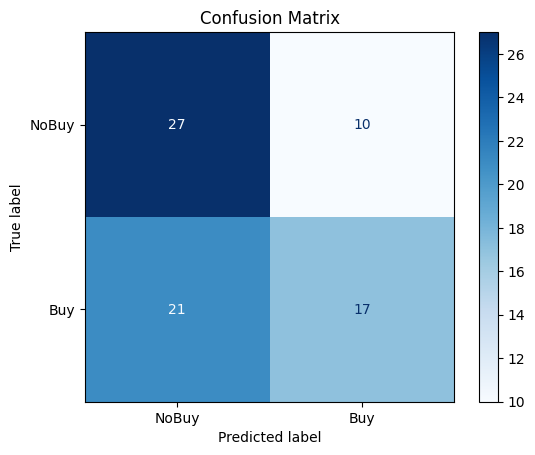

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NoBuy', 'Buy'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.73      0.64        37
         1.0       0.63      0.45      0.52        38

    accuracy                           0.59        75
   macro avg       0.60      0.59      0.58        75
weighted avg       0.60      0.59      0.58        75



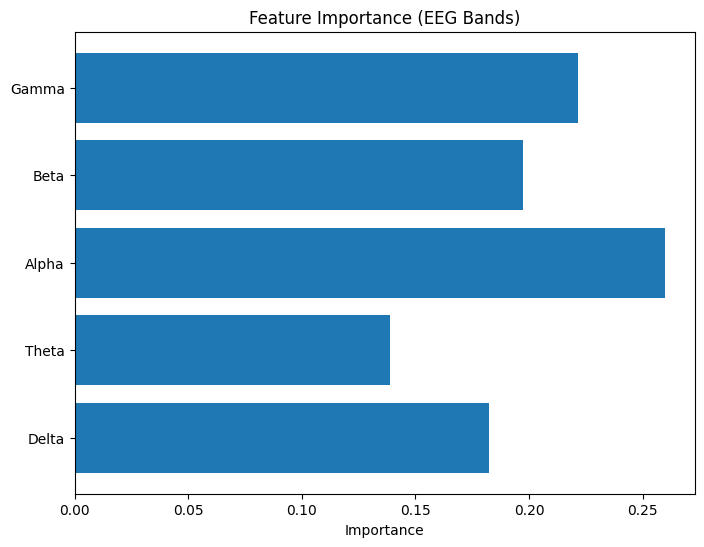

In [ ]:
import numpy as np

# Get feature importance from the trained Random Forest model
feature_importances = model.feature_importances_

# Plot feature importance
features = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
plt.figure(figsize=(8, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.title('Feature Importance (EEG Bands)')
plt.show()


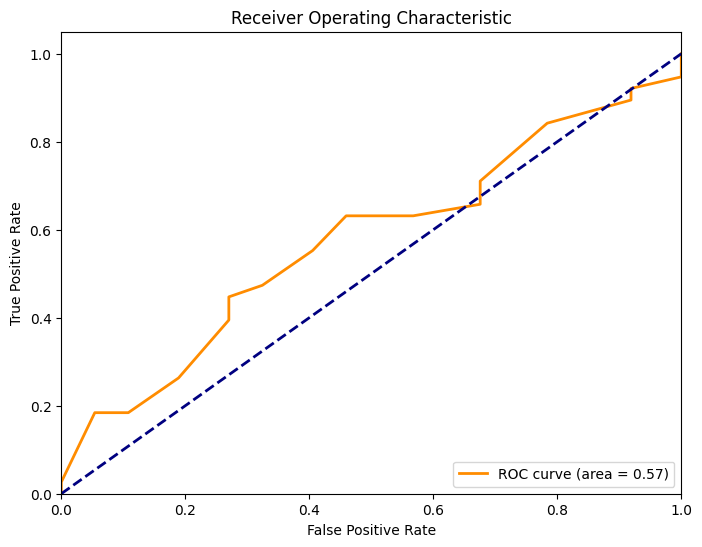

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


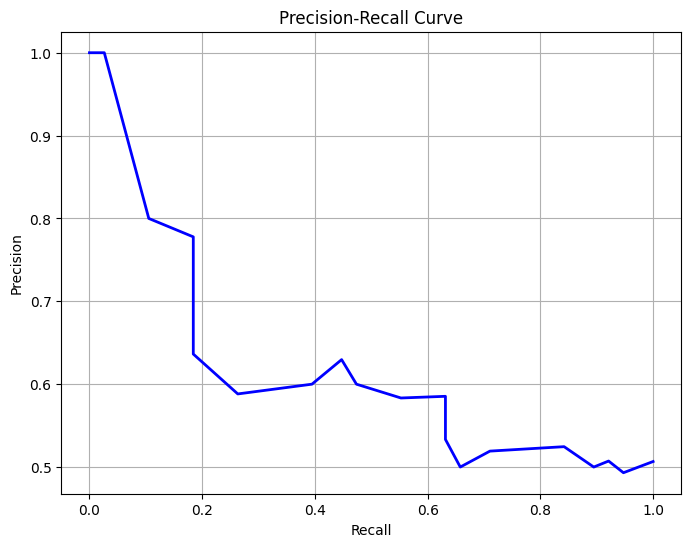

In [ ]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


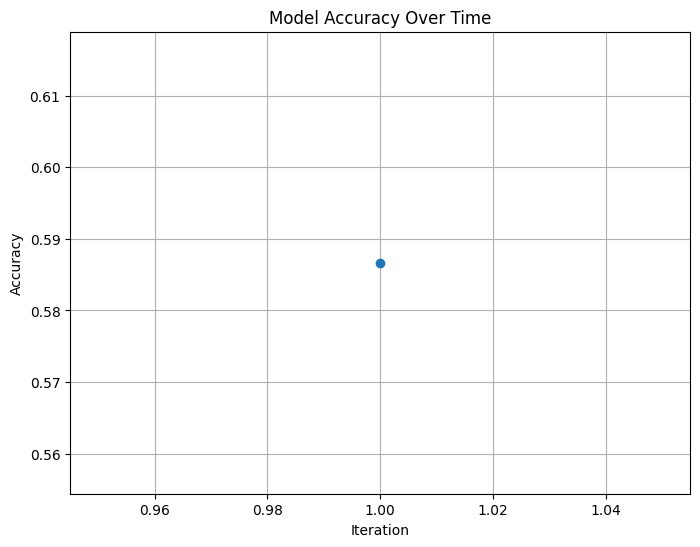

In [ ]:
# Example: track accuracy over different iterations
accuracies = []  # Example: Add accuracy after each iteration

# Inside your training loop (if using GridSearchCV or other iterators)
accuracies.append(accuracy_score(y_test, y_pred))  # After each iteration of training

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(accuracies)+1), accuracies, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Time')
plt.grid(True)
plt.show()


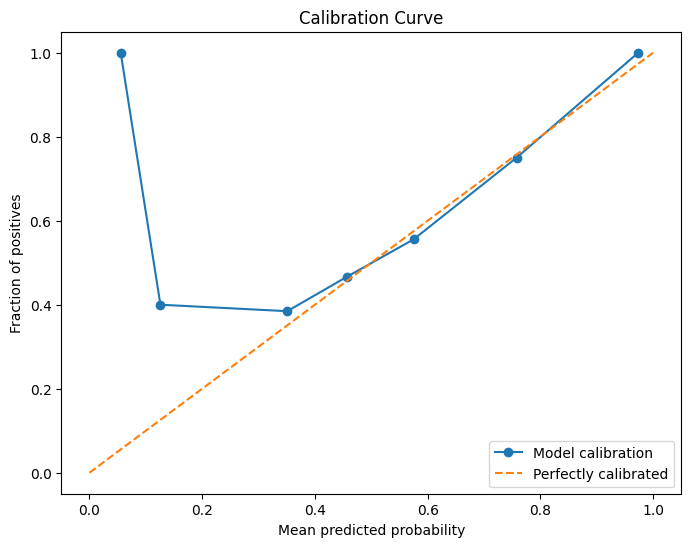

In [ ]:
from sklearn.calibration import calibration_curve

# Calibration Curve
prob_pos = model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Model calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend(loc='best')
plt.show()


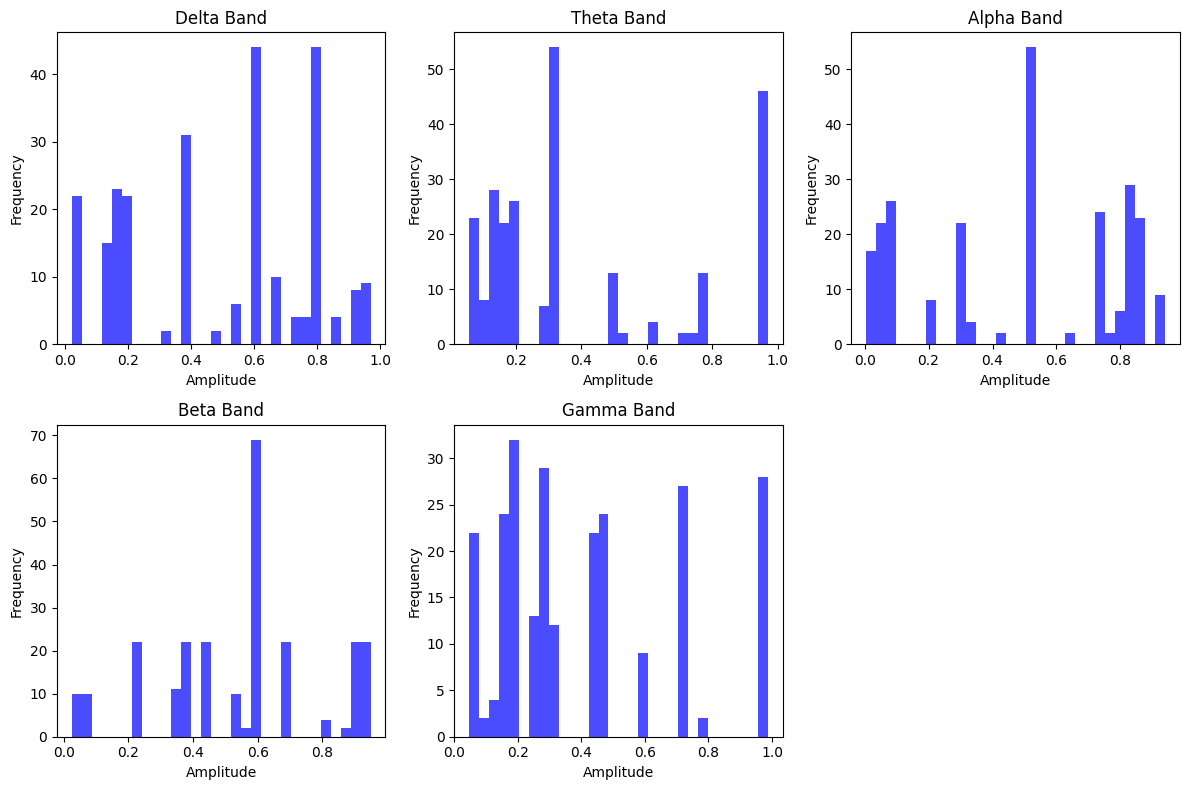

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram for each EEG band
features = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
plt.figure(figsize=(12, 8))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    plt.hist(X_total[:, i], bins=30, alpha=0.7, color='b')
    plt.title(f'{feature} Band')
    plt.xlabel('Amplitude')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


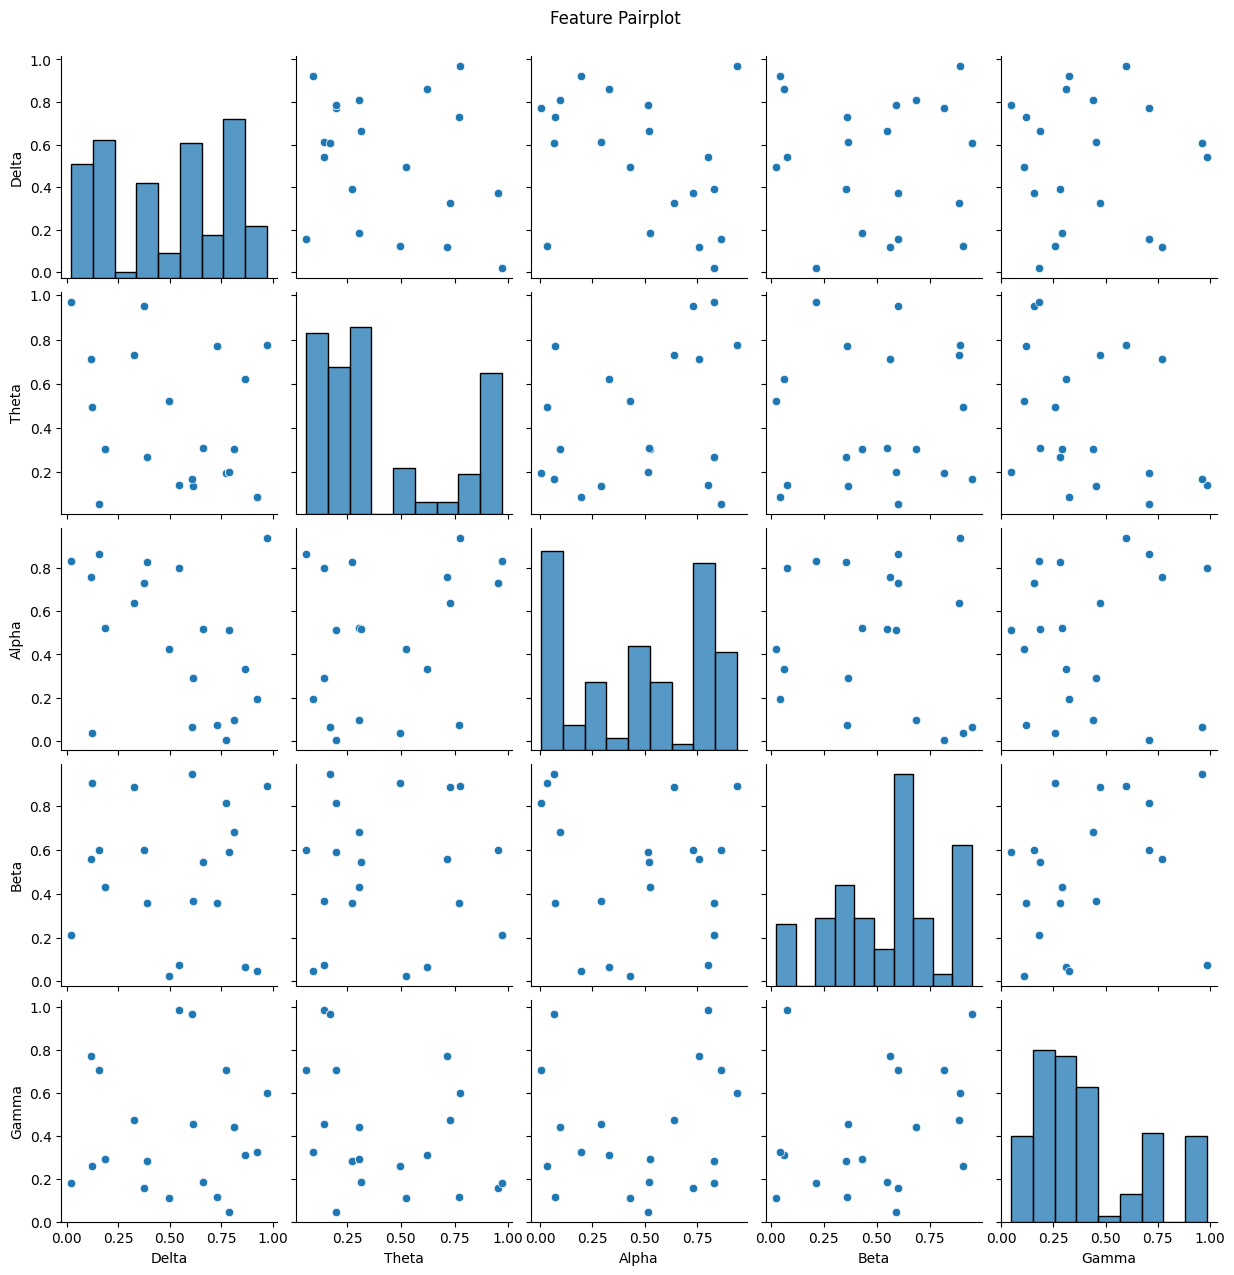

In [ ]:
import seaborn as sns
import pandas as pd

# Create a DataFrame to visualize relationships between features
df_features = pd.DataFrame(X_total, columns=features)
sns.pairplot(df_features)
plt.suptitle('Feature Pairplot', y=1.02)
plt.show()


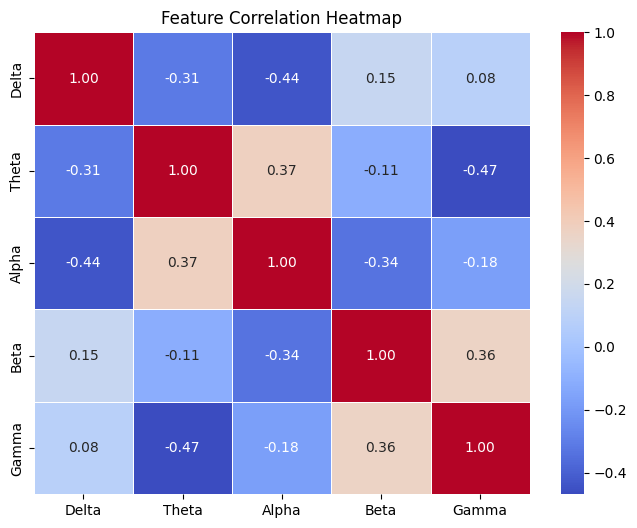

In [ ]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for correlation
df_corr = pd.DataFrame(X_total, columns=features)
corr_matrix = df_corr.corr()

# Plot heatmap of feature correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


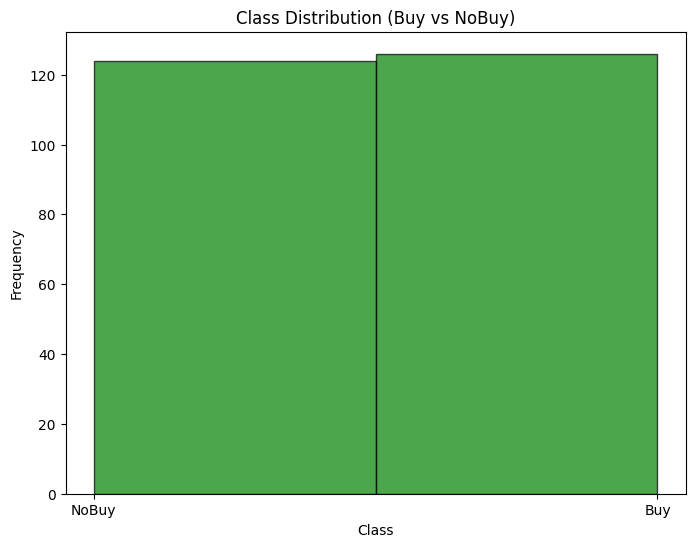

In [ ]:
# Plot the distribution of Buy vs NoBuy labels
plt.figure(figsize=(8, 6))
plt.hist(y_total, bins=2, alpha=0.7, color='g', edgecolor='black')
plt.title('Class Distribution (Buy vs NoBuy)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['NoBuy', 'Buy'])
plt.show()


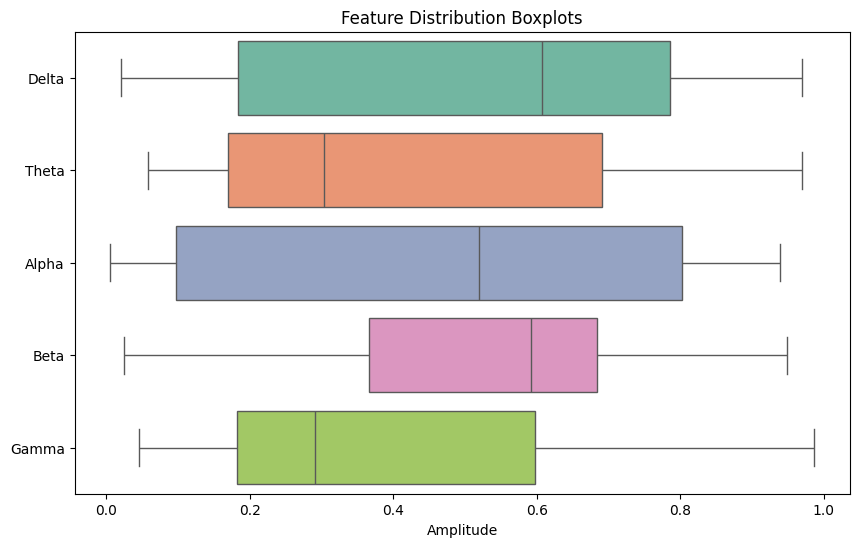

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_features, orient='h', palette='Set2')
plt.title('Feature Distribution Boxplots')
plt.xlabel('Amplitude')
plt.show()


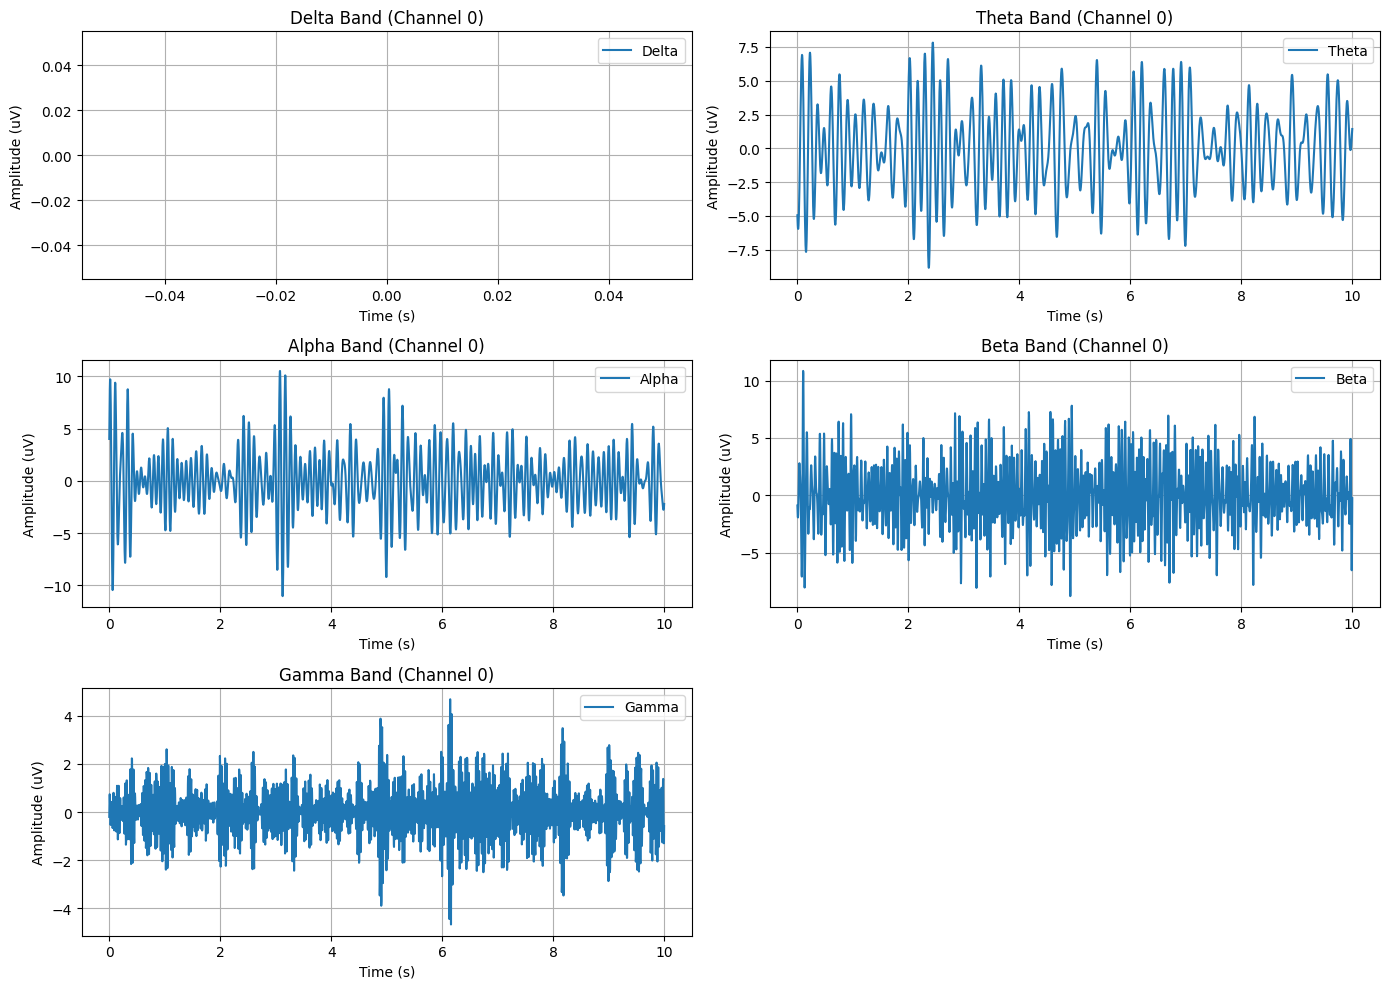

In [ ]:
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import numpy as np

# Define function to bandpass filter EEG signal for a specific frequency band
def bandpass_filter(eeg_signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, eeg_signal, axis=1)

# Plot function for all EEG bands
def plot_eeg_bands(eeg_data, fs=300, channel_idx=0, duration=10):
    """
    Plots the EEG signals in the Delta, Theta, Alpha, Beta, and Gamma bands for a given channel.
    Args:
    - eeg_data: The EEG data (channels x timepoints).
    - fs: Sampling frequency (Hz).
    - channel_idx: The index of the channel to plot.
    - duration: Duration (in seconds) to plot.
    """
    # Time array (for plotting)
    time = np.linspace(0, duration, int(duration * fs))

    # Define frequency bands (Hz)
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 45)
    }

    # Create a figure for plotting
    plt.figure(figsize=(14, 10))

    # Loop through each band and plot the filtered signal
    for i, (band_name, (lowcut, highcut)) in enumerate(bands.items()):
        filtered_signal = bandpass_filter(eeg_data, lowcut, highcut, fs)

        plt.subplot(3, 2, i+1)
        plt.plot(time, filtered_signal[channel_idx, :len(time)], label=band_name)
        plt.title(f'{band_name} Band (Channel {channel_idx})')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (uV)')
        plt.grid(True)
        plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Example usage: Plot EEG data for first 10 seconds of the first channel
plot_eeg_bands(eeg_clean, fs=300, channel_idx=0, duration=10)


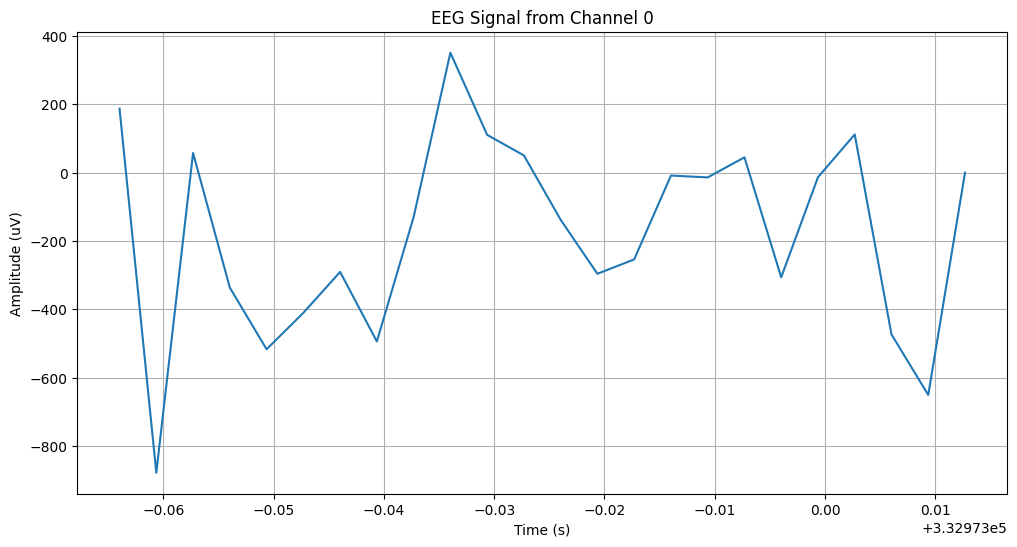

In [ ]:
# Load the .xdf file
streams, header = pyxdf.load_xdf('S01.xdf')

# Extract EEG stream
eeg_stream = None
for stream in streams:
    if stream['info']['type'][0] == "EEG":
        eeg_stream = stream
        break

# Ensure eeg_times and eeg_signal have the same length
eeg_times = eeg_stream['time_stamps']  # Timestamps of the EEG data (length: n_samples)
eeg_data = eeg_stream['time_series']  # Raw EEG data (shape: n_channels, n_samples)

# Select the first channel (channel 0)
channel_idx = 0
eeg_signal = eeg_data[channel_idx]  # Data from the first channel

# Ensure the lengths match by trimming or interpolating if necessary
if len(eeg_times) > len(eeg_signal):
    eeg_times = eeg_times[:len(eeg_signal)]  # Trim times if they are longer
elif len(eeg_times) < len(eeg_signal):
    eeg_signal = eeg_signal[:len(eeg_times)]  # Trim the signal if it's longer

# Plotting the EEG signal from the selected channel
plt.figure(figsize=(12, 6))
plt.plot(eeg_times, eeg_signal)  # Plot EEG data from channel 0
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title(f'EEG Signal from Channel {channel_idx}')
plt.grid(True)
plt.show()



In [ ]:
# Extract the EEG stream
eeg_stream = None
for stream in streams:
    if stream['info']['type'][0] == "EEG":
        eeg_stream = stream
        break

# Extract the EEG data
eeg_data = eeg_stream['time_series']  # Shape: (channels, timepoints)

# Number of channels in the EEG data
num_channels = eeg_data.shape[0]

print(f"Number of EEG channels: {num_channels}")


Number of EEG channels: 110555


In [ ]:
# Check the shape of the EEG data to confirm channels and timepoints
eeg_data = eeg_stream['time_series']  # EEG signal (channels x timepoints)

# Print shape of the EEG data
print(f"EEG Data Shape: {eeg_data.shape}")

# Get number of channels (rows)
num_channels = eeg_data.shape[0]
print(f"Number of EEG Channels: {num_channels}")

# Get the number of timepoints (columns)
num_timepoints = eeg_data.shape[1]
print(f"Number of Timepoints: {num_timepoints}")


EEG Data Shape: (110555, 24)
Number of EEG Channels: 110555
Number of Timepoints: 24


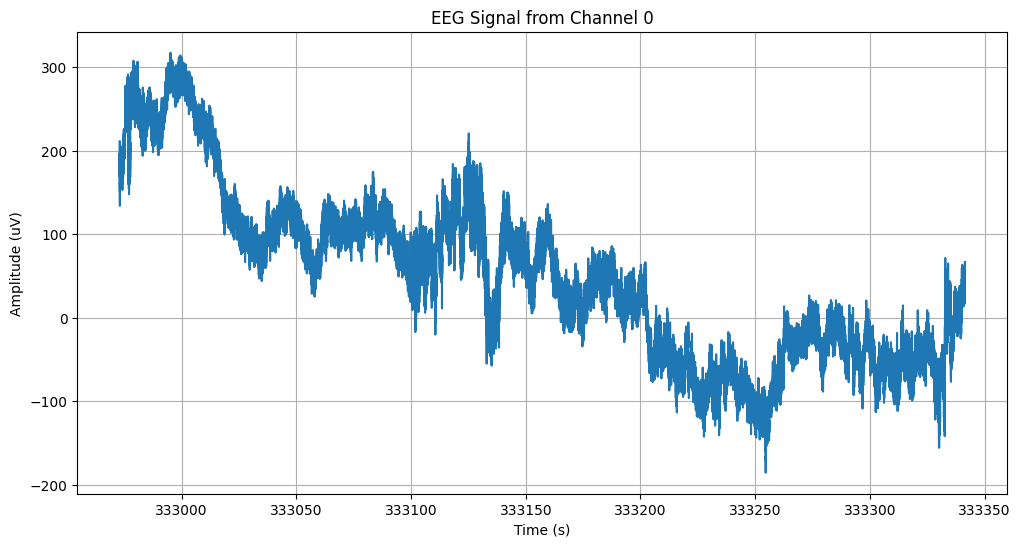

In [ ]:
# Make sure eeg_times and eeg_data have the same number of samples
eeg_times = eeg_stream['time_stamps']  # Timestamps of the EEG data (length: n_samples)
eeg_data = eeg_stream['time_series']  # Raw EEG data (shape: n_samples, n_channels)

# Ensure eeg_times and eeg_data have the same length
if len(eeg_times) != eeg_data.shape[0]:
    # If they are mismatched, trim or synchronize the data
    min_len = min(len(eeg_times), eeg_data.shape[0])
    eeg_times = eeg_times[:min_len]  # Trim the times array
    eeg_data = eeg_data[:min_len, :]  # Trim the EEG signal array

# Select a channel (e.g., channel 0 for the first one)
channel_idx = 0  # Change this index to plot data from a different channel

# Plot EEG signal from the selected channel
plt.figure(figsize=(12, 6))
plt.plot(eeg_times, eeg_data[:, channel_idx])  # eeg_data has shape (timepoints, channels)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title(f'EEG Signal from Channel {channel_idx}')
plt.grid(True)
plt.show()
